# Re-identification of records

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
df = pd.read_csv("raw_data.txt", delimiter=r"\s+")
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='s')
df.set_index('TIMESTAMP', inplace=True)

# Define variables

In [3]:
# define scale
GRID_DEFINITION = 15
NB_POI = 3

In [4]:
df.head()

,ID,LATITUDE,LONGITUDE
TIMESTAMP,,,
2014-12-07 01:13:49,11,4.871345,45.776045
2014-12-07 01:14:49,11,4.871457,45.775903
2014-12-07 01:15:49,11,4.871273,45.775905
2014-12-07 01:16:49,11,4.871337,45.775867
2014-12-07 01:17:49,11,4.871228,45.775907


## Dataset properties

In [5]:
len(df.ID.unique())

92

In [6]:
df[df.ID == 11]

,ID,LATITUDE,LONGITUDE
TIMESTAMP,,,
2014-12-07 01:13:49,11,4.871345,45.776045
2014-12-07 01:14:49,11,4.871457,45.775903
2014-12-07 01:15:49,11,4.871273,45.775905
2014-12-07 01:16:49,11,4.871337,45.775867
2014-12-07 01:17:49,11,4.871228,45.775907
...,...,...,...
2014-12-19 15:37:26,11,4.871218,45.776108
2014-12-19 15:38:43,11,4.871228,45.776093
2014-12-19 16:38:29,11,4.871518,45.775938


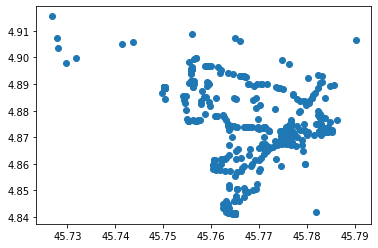

In [7]:
plt.scatter(x=df[df.ID == 11]['LONGITUDE'], y=df[df.ID == 11]['LATITUDE'])
plt.show()

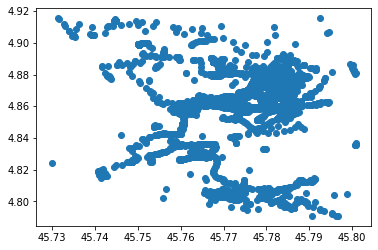

In [8]:
plt.scatter(x=df[df.ID == 42]['LONGITUDE'], y=df[df.ID == 42]['LATITUDE'])
plt.show()

## Create grill

In [9]:
df.describe()

,ID,LATITUDE,LONGITUDE
count,829506.000000,829506.000000,829506.000000
mean,42.899221,4.868840,45.772308
std,24.880798,0.013379,0.013498
min,1.000000,4.790898,45.715932
25%,25.000000,4.866228,45.762708
50%,44.000000,4.871318,45.778376
75%,67.000000,4.873620,45.784103
max,116.000000,4.915523,45.800955


### Create longitude and latitude bins

In [10]:
def createBins(df, GRID_DEFINITION):
    MIN, MAX = df['LATITUDE'].min(), df['LATITUDE'].max()

    STEP = (MAX - MIN) / GRID_DEFINITION

    latitude_grill = np.arange(MIN, MAX, STEP)
    print("Nombre de bins pour latitude {}".format(len(latitude_grill)))
    
    MIN, MAX = df['LONGITUDE'].min(), df['LONGITUDE'].max()

    STEP = (MAX - MIN) / GRID_DEFINITION

    longitude_grill = np.arange(MIN, MAX, STEP)
    print("Nombre de bins pour longitude {}".format(len(longitude_grill)))
    
    return latitude_grill, longitude_grill

In [11]:
def compute_POI(user, df_users, nb_POI=1):
    # List initialization 
    Input = list(zip(df_users[user]["new_longitude"], df_users[user]["new_latitude"]))

    list_POI = Counter(elem for elem in Input).most_common(nb_POI)
    coordinates, freq = zip(*list_POI)
    return coordinates

In [12]:
users = df.ID.unique()

In [13]:
latitude_grill, longitude_grill = createBins(df, GRID_DEFINITION)

Nombre de bins pour latitude 15
Nombre de bins pour longitude 15


In [14]:
df_users = {}

# Create dictionnay of values with converted longitude and latitude
for user in users:
    temp_dict = {}
    temp_dict["new_longitude"] = pd.cut(df[df.ID == user]['LONGITUDE'], bins=longitude_grill, right=True, labels=False).to_list()
    temp_dict["new_latitude"]  = pd.cut(df[df.ID == user]['LATITUDE'],  bins=latitude_grill,  right=True, labels=False).to_list()
    df_users[user] = temp_dict

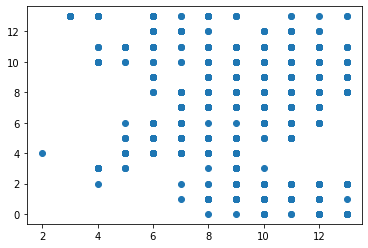

In [15]:
USER = 42
plt.scatter(x=df_users[USER]["new_longitude"], y=df_users[USER]["new_latitude"])
plt.show()

In [16]:
res = {}
for user in users:
    res[user] = compute_POI(user, df_users, nb_POI=NB_POI)

### Plot an example

In [17]:
x = [list(t) for t in zip(*res[USER])][0]
y = [list(t) for t in zip(*res[USER])][1]

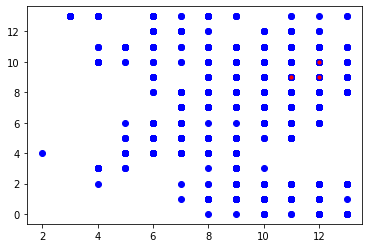

In [18]:
plt.scatter(x=df_users[USER]["new_longitude"], y=df_users[USER]["new_latitude"], c='b')
plt.scatter(x=x, y=y, s=10, c='r')
plt.show()

# Compute RMSE between original and obfuscated

## Load obfuscated file

## Compute distance

In [19]:
def compute_distance(tuple1, tuple2):
    dimension = len(tuple1)
    
    if(dimension != len(tuple2)):
        return np.inf
        
    distance = 0
    
    for i in range(dimension):
        distance += (tuple1[i][0] - tuple2[i][0])**2 + (tuple1[i][1] - tuple2[i][1])**2
    return distance

In [20]:
def compute_success_from_file(filename, NB_POI, GRID_DEFINITION):
    df2 = pd.read_csv(filename, delimiter=r"\s+")
    
    # Compute Grid with alterated values
    latitude_grill2, longitude_grill2 = createBins(df2, GRID_DEFINITION)

    # Retrieve user list
    users = df2.ID.unique()

    df2_users = {}

    # Create dictionnay of values with converted longitude and latitude
    for user in users:
        temp_dict = {}
        temp_dict["new_longitude"] = pd.cut(df2[df2.ID == user]['LONGITUDE'], bins=longitude_grill2, right=True, labels=False).to_list()
        temp_dict["new_latitude"]  = pd.cut(df2[df2.ID == user]['LATITUDE'],  bins=latitude_grill2,  right=True, labels=False).to_list()
        df2_users[user] = temp_dict
        
    # FInd POI
    res2 = {}
    for user in users:
        res2[user] = compute_POI(user, df2_users, nb_POI=NB_POI)
        
    # Select a user we will re-identify
    predict_count = 0

    for SELECTED_USER in users:

        list_distance = []

        for user in users:
            distance = compute_distance(res[SELECTED_USER], res2[user])
            list_distance.append(distance)

        if (SELECTED_USER == users[np.argmin(list_distance)]):
            predict_count += 1

        #print("{} is {} in OBFUSCATED with distance : {} ".format(SELECTED_USER, users[np.argmin(list_distance)], min(list_distance)))

    print("Success rate {}".format(predict_count/len(users)))

In [21]:
compute_success_from_file(filename="bruit_faible.txt", NB_POI=NB_POI, GRID_DEFINITION=GRID_DEFINITION)

Nombre de bins pour latitude 15
Nombre de bins pour longitude 15
Success rate 0.8804347826086957


In [22]:
compute_success_from_file(filename="bruit_moyen.txt", NB_POI=NB_POI, GRID_DEFINITION=GRID_DEFINITION)

Nombre de bins pour latitude 16
Nombre de bins pour longitude 15
Success rate 0.31521739130434784


In [23]:
compute_success_from_file(filename="bruit_fort.txt", NB_POI=NB_POI, GRID_DEFINITION=GRID_DEFINITION)

Nombre de bins pour latitude 15
Nombre de bins pour longitude 15
Success rate 0.08695652173913043
